You will need to have the CytoSummaryNet profiles and average profiles for Stain3 to be able to run this code. You will need to first train a model on all Stain datasets (except for Stain5) and run inference on the holdouts to get these profiles. The average profiles can be obtained through manual processing or through downloading them from:
https://github.com/jump-cellpainting/pilot-data-public

In [3]:
import sys
from pathlib import Path
import os

ROOT_DIR = Path(os.getcwd()).resolve().parent
if (ROOT_DIR / "networks").exists():
    sys.path.append(str(ROOT_DIR))
else:
    raise FileNotFoundError("Root directory does not contain expected structure. Please adjust ROOT_DIR.")

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import umap.plot
from pycytominer.operations.transform import RobustMAD
from pycytominer import feature_select
import plotly.express as px

dataset_name = 'Stain3'

output_root_dir = '/Users/rdijk/Documents/ProjectFA/FinalModelResults/UMAP/'

top_x_moa = 15
MOAs = fr'/Users/rdijk/Documents/ProjectFA/results/cpg0001/mAP/{dataset_name}/bestMOAs_{dataset_name}.csv' 
MOAs = pd.read_csv(MOAs)
MOAs = MOAs.sort_values(by = len(MOAs)-1, axis = 1, ascending=False)
bestMOAs = MOAs.iloc[:, :top_x_moa].columns

rootDir_MLP = fr'/Users/rdijk/PycharmProjects/featureAggregation/outputs/FinalProfiles/{dataset_name}'
rootdir_BM = fr'/Users/rdijk/Documents/Data/ProcessedData/{dataset_name}/profiles'
MLP_platedirs = [x for x in os.walk(rootDir_MLP)][0][1:][1]
MLP_platenames = [x.split('_')[-1] for x in MLP_platedirs]

BM_platedirs = [x for x in os.walk(rootdir_BM)][0][2]
BM_platedirs = [x for x in BM_platedirs if x in MLP_platenames]

MLP_platedirs.sort()
BM_platedirs.sort()

commonFeatureNames = pd.read_csv('/Users/rdijk/Documents/Data/RawData/CommonFeatureNames.csv', index_col=False)
commonFeatureNames = [x.split('.')[1] for x in commonFeatureNames.iloc[:, 0]]
commonFeatureNames.append('label')
commonFeatureNames.append('pert_iname')

metadata = pd.read_csv('/inputs/cpg0001_metadata/JUMP-MOA_compound_platemap_with_metadata.csv',
                       index_col=False)
metadata = metadata[metadata.control_type != 'negcon'].reset_index()

MLPdfs = []
BMdfs = []
i = 0
negconsStain = ["A11", "B18", "D17", "D19", "E07", "E08", "F07", "F24", "G20", "G23", "H10", "I12", "I13", "J01", "J21",
                "K24", "M05", "M06", "N06", "N22", "O14", "O19", "P02", "P11"]

for MLP, BM in zip(MLP_platedirs, BM_platedirs):
    lblsMLP = [MLP_platenames[i][:-4]] * 360
    lblsBM = [MLP_platenames[i][:-4]] * 384

    temp1 = pd.concat([pd.read_csv(os.path.join(rootDir_MLP, MLP), index_col=False), pd.Series(lblsMLP, name='label')], axis=1)
    temp1['well_name'] = metadata['well_position']
    temp1['pert_iname'] = metadata['pert_iname']
    temp1['moa'] = metadata['moa']
    
    # sort compounds by training/validation compound and split data
    #temp1 = temp1.sort_values(by='pert_iname').iloc[:288, :]
    #temp1 = temp1.sort_values(by='pert_iname').iloc[288:, :]
    temp1 = temp1.sort_values(by='pert_iname')

    #MLPdfs.append(temp1)
    MLPdfs.append(temp1[temp1.moa.isin(bestMOAs)])

    temp2 = pd.concat([pd.read_csv(os.path.join(rootdir_BM, BM), index_col=False), pd.Series(lblsBM, name='label')], axis=1)
    features = temp2[commonFeatureNames[:-2]]
    scaler = RobustMAD()
    fitted_scaler = scaler.fit(features)
    features = fitted_scaler.transform(features)
    # features = features.dropna(axis=1, how='any')
    # features = feature_select(features, operation=["variance_threshold", "correlation_threshold",
    #                                                 "drop_na_columns", "blocklist"])

    features['label'] = temp2['label']
    features = features[~temp2.Metadata_Well.isin(negconsStain)].reset_index(drop=True) # remove negcons
    features['well_name'] = metadata['well_position']
    features['pert_iname'] = metadata['pert_iname']
    features['moa'] = metadata['moa']

    #features = features.sort_values(by='pert_iname').iloc[:288, :]
    #features = features.sort_values(by='pert_iname').iloc[288:, :]
    features = features.sort_values(by='pert_iname')

    #BMdfs.append(features)
    BMdfs.append(features[features.moa.isin(bestMOAs)])
    i += 1


# Calculate UMAPs

In [2]:
#%% Hyperparameters used
n_neighbors = 15 # [3, 15, 75, 375]
fig_width = 800
fig_height = 600
dpi=600

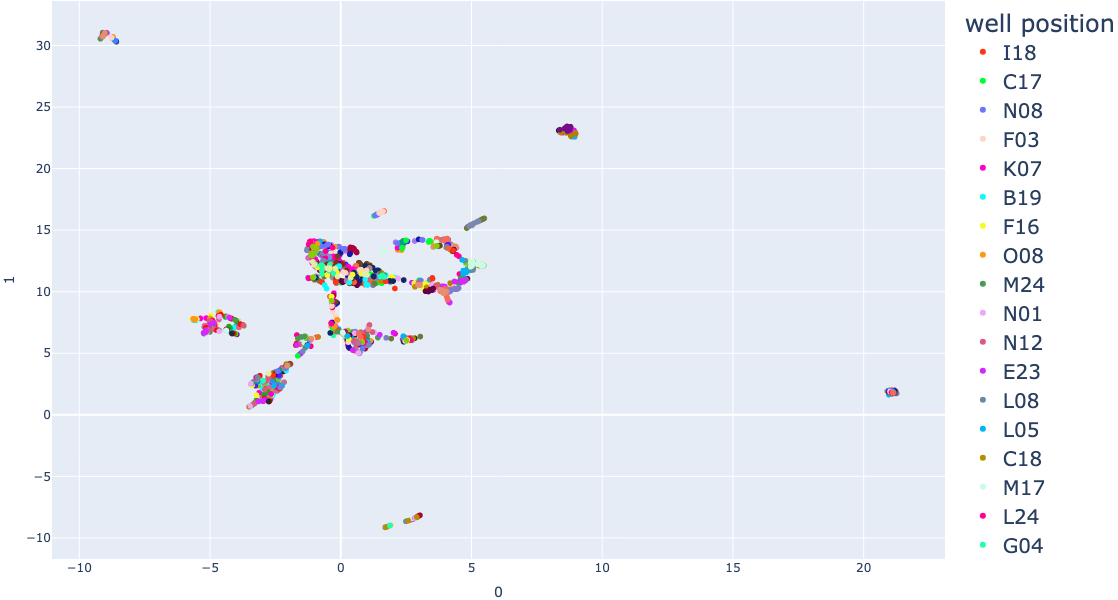

<Figure size 8400x8400 with 0 Axes>

In [3]:
# %% Create UMap
plt.figure(figsize=(14, 14), dpi=dpi)
BMDF = pd.concat([x for x in BMdfs])
featuresBM = BMDF.iloc[: , :-4]
labels = BMDF.iloc[:, -3]
hover_data = pd.DataFrame({'label': labels})

reducer = umap.UMAP(random_state=42, metric='cosine', n_neighbors=n_neighbors)
embedding1 = reducer.fit(featuresBM)

fig = px.scatter(
    embedding1.embedding_, x=0, y=1,
    color=hover_data.label, labels={'color': 'well position'},
    color_discrete_sequence=px.colors.qualitative.Light24 + px.colors.qualitative.Dark24
)

fig.update_xaxes(fixedrange=True)
fig.update_yaxes(fixedrange=True)

fig.update_layout(
    autosize=False,
    width=fig_width,
    height=fig_height,
    margin=dict(l=1, r=1, t=1, b=1),
    legend=dict(font=dict(size= 20))
)
fig.show()


save_path = output_root_dir + f'{dataset_name}/UMAPbmWell_{n_neighbors}_{dataset_name}.png'
fig.write_image(save_path, scale=3)


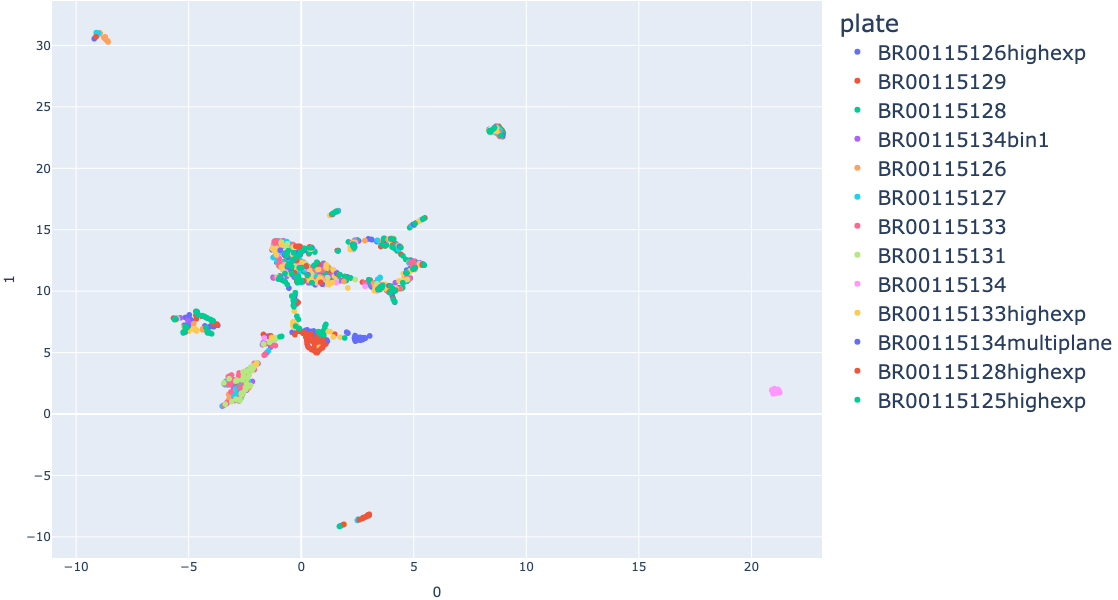

<Figure size 8400x8400 with 0 Axes>

In [4]:
plt.figure(figsize=(14, 14), dpi=dpi)
labels = BMDF.iloc[:, -4] # -4 --> well / -3 --> plate / -2 --> compound / -1 --> moa
hover_data = pd.DataFrame({'label': labels})

fig = px.scatter(
    embedding1.embedding_, x=0, y=1,
    color=hover_data.label, labels={'color': 'plate'},
)

fig.update_xaxes(fixedrange=True)
fig.update_yaxes(fixedrange=True)

fig.update_layout(
    autosize=False,
    width=fig_width,
    height=fig_height,
    margin=dict(l=1, r=1, t=1, b=1),
    legend=dict(font=dict(size= 20))
)
fig.show()

save_path = output_root_dir + f'{dataset_name}/UMAPbmPlate_{n_neighbors}_{dataset_name}.png'
fig.write_image(save_path, scale=3)

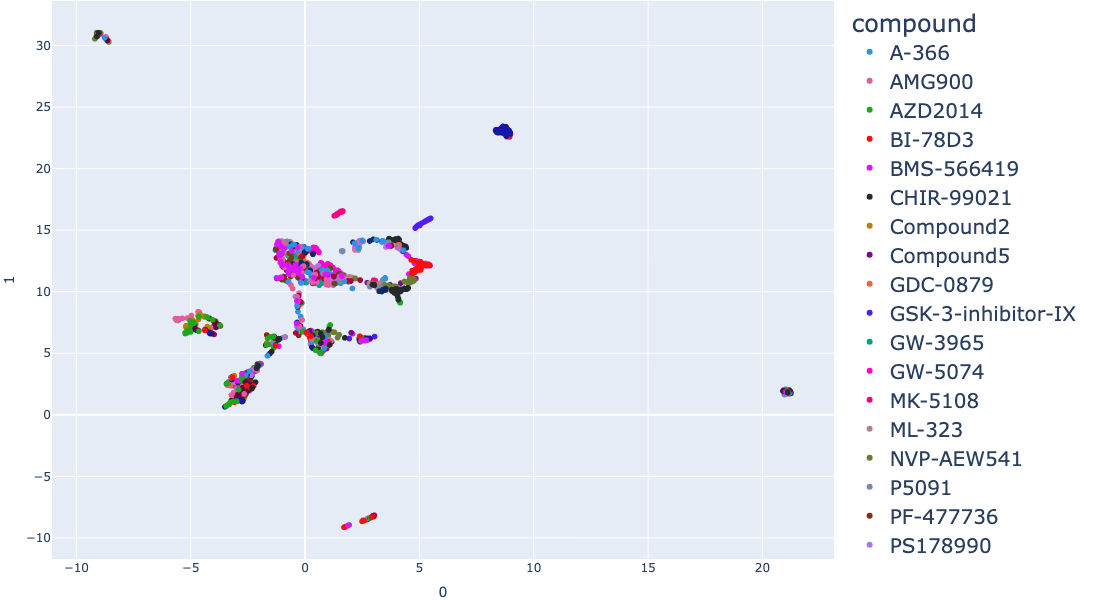

<Figure size 8400x8400 with 0 Axes>

In [5]:
plt.figure(figsize=(14, 14), dpi=dpi)
labels = BMDF.iloc[:, -2] # -3 --> plate / -2 --> compound / -1 --> moa
hover_data = pd.DataFrame({'label': labels})

fig = px.scatter(
    embedding1.embedding_, x=0, y=1,
    color=hover_data.label, labels={'color': 'compound'},
    color_discrete_sequence=px.colors.qualitative.Dark24
)

fig.update_xaxes(fixedrange=True)
fig.update_yaxes(fixedrange=True)

fig.update_layout(
    autosize=False,
    width=fig_width,
    height=fig_height,
    margin=dict(l=1, r=1, t=1, b=1),
    legend=dict(font=dict(size= 20))
)
fig.show()

save_path = output_root_dir + f'{dataset_name}/UMAPbmCompound_{n_neighbors}_{dataset_name}.png'
fig.write_image(save_path, scale=3)

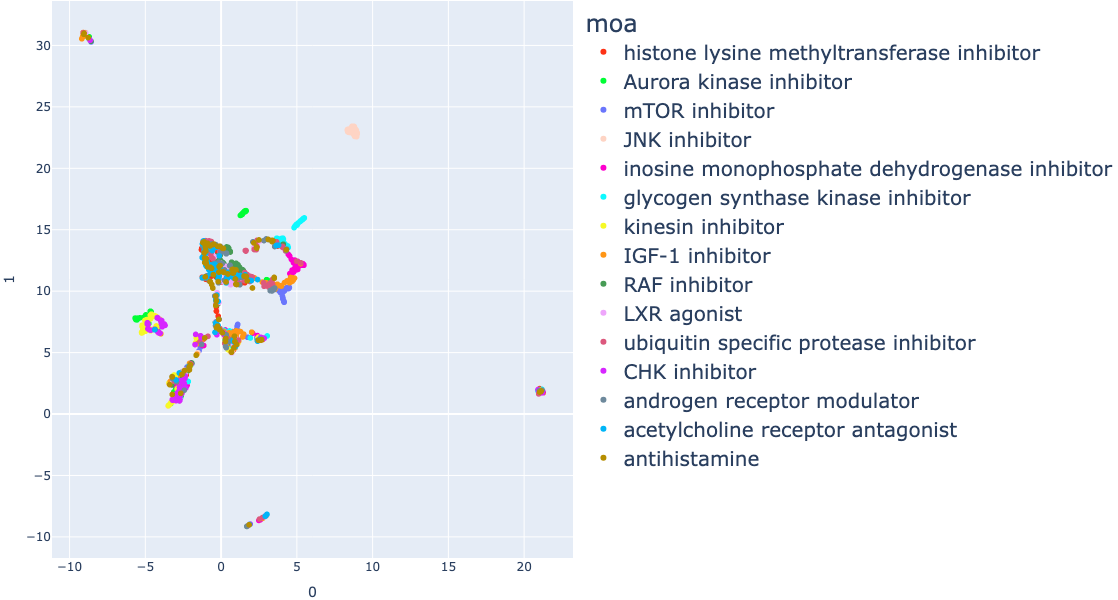

<Figure size 8400x8400 with 0 Axes>

In [6]:
plt.figure(figsize=(14, 14), dpi=dpi)
labels = BMDF.iloc[:, -1] # -3 --> plate / -2 --> compound / -1 --> moa
hover_data = pd.DataFrame({'label': labels})

fig = px.scatter(
    embedding1.embedding_, x=0, y=1,
    color=hover_data.label, labels={'color': 'moa'},
    color_discrete_sequence=px.colors.qualitative.Light24
)

fig.update_xaxes(fixedrange=True)
fig.update_yaxes(fixedrange=True)

fig.update_layout(
    autosize=False,
    width=fig_width+400,
    height=fig_height,
    margin=dict(l=1, r=1, t=1, b=1),
    legend=dict(font=dict(size= 20))
)
fig.show()

save_path = output_root_dir + f'{dataset_name}/UMAPbmMOA_{n_neighbors}_{dataset_name}.png'
fig.write_image(save_path, scale=3)

# MLP UMAPs

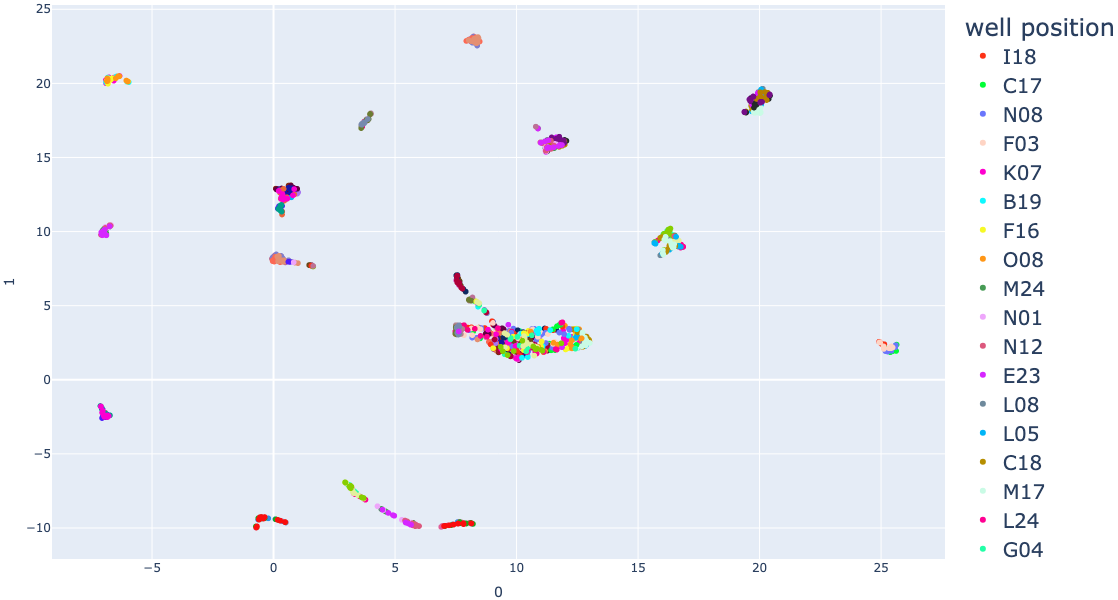

<Figure size 8400x8400 with 0 Axes>

In [7]:
plt.figure(figsize=(14, 14), dpi=dpi)
MLPDF = pd.concat([x for x in MLPdfs])
featuresMLP = MLPDF.iloc[:, :-4]
labels = MLPDF.iloc[:, -3]
hover_data = pd.DataFrame({'label': labels})

reducer = umap.UMAP(random_state=42, metric='cosine', n_neighbors=n_neighbors)
embedding2 = reducer.fit(featuresMLP)

fig = px.scatter(
    embedding2.embedding_, x=0, y=1,
    color=hover_data.label, labels={'color': 'well position'},
    color_discrete_sequence=px.colors.qualitative.Light24 + px.colors.qualitative.Dark24
)

fig.update_xaxes(fixedrange=True)
fig.update_yaxes(fixedrange=True)

fig.update_layout(
    autosize=False,
    width=fig_width,
    height=fig_height,
    margin=dict(l=1, r=1, t=1, b=1),
    legend=dict(font=dict(size= 20))
)
fig.show()

save_path = output_root_dir + f'{dataset_name}/UMAPmlpWell_{n_neighbors}_{dataset_name}.png'
fig.write_image(save_path, scale=3)

In [8]:
MLPDF.shape[0]

1560

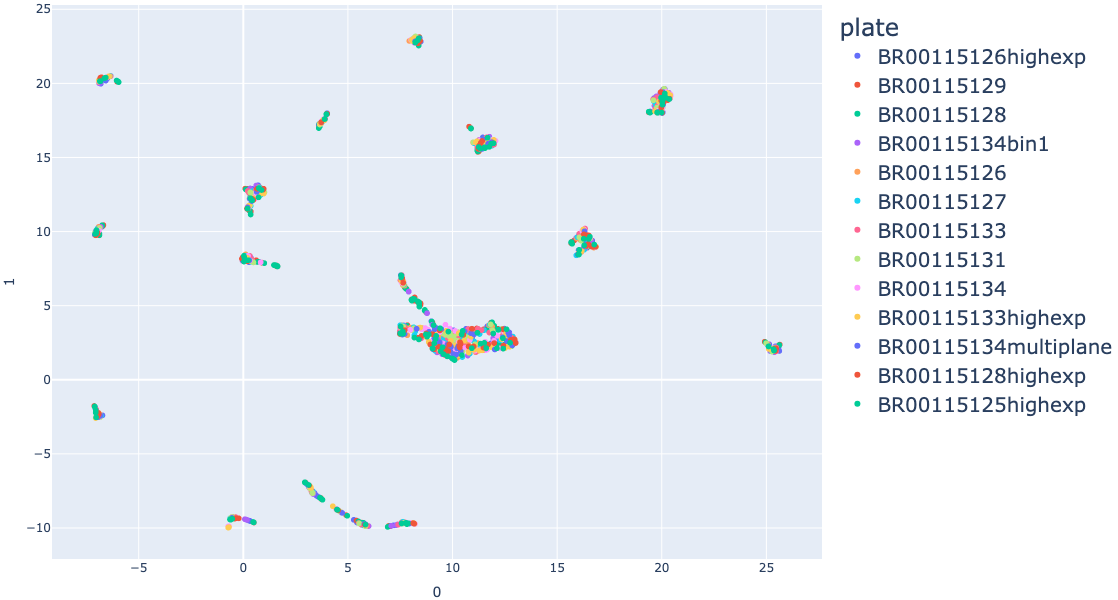

<Figure size 8400x8400 with 0 Axes>

In [9]:
plt.figure(figsize=(14, 14), dpi=dpi)
labels = MLPDF.iloc[:, -4]
hover_data = pd.DataFrame({'label': labels})

fig = px.scatter(
    embedding2.embedding_, x=0, y=1,
    color=hover_data.label, labels={'color': 'plate'}
)

fig.update_xaxes(fixedrange=True)
fig.update_yaxes(fixedrange=True)

fig.update_layout(
    autosize=False,
    width=fig_width,
    height=fig_height,
    margin=dict(l=1, r=1, t=1, b=1),
    legend=dict(font=dict(size= 20))
)

fig.show()

save_path = output_root_dir + f'{dataset_name}/UMAPmlpPlate_{n_neighbors}_{dataset_name}.png'
fig.write_image(save_path, scale=3)

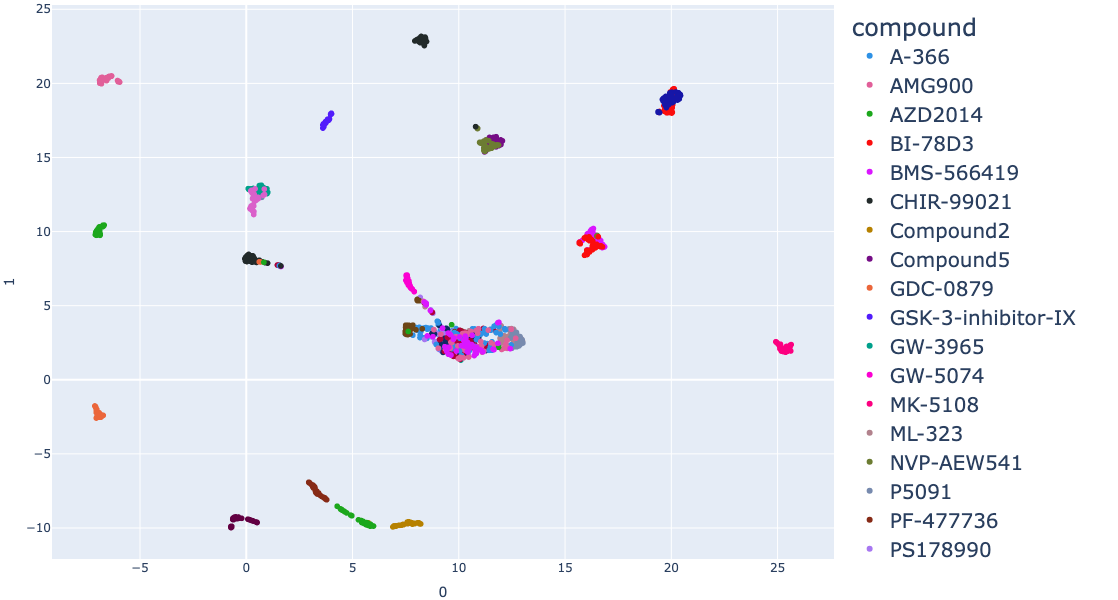

<Figure size 8400x8400 with 0 Axes>

In [10]:
plt.figure(figsize=(14, 14), dpi=dpi)
labels = MLPDF.iloc[:, -2]
hover_data = pd.DataFrame({'label': labels})

fig = px.scatter(
    embedding2.embedding_, x=0, y=1,
    color=hover_data.label, labels={'color': 'compound'},
    color_discrete_sequence=px.colors.qualitative.Dark24
)

fig.update_xaxes(fixedrange=True)
fig.update_yaxes(fixedrange=True)

fig.update_layout(
    autosize=False,
    width=fig_width,
    height=fig_height,
    margin=dict(l=1, r=1, t=1, b=1),
    legend=dict(font=dict(size= 20))
)
fig.show()


save_path = output_root_dir + f'{dataset_name}/UMAPmlpCompound_{n_neighbors}_{dataset_name}.png'
fig.write_image(save_path, scale=3)

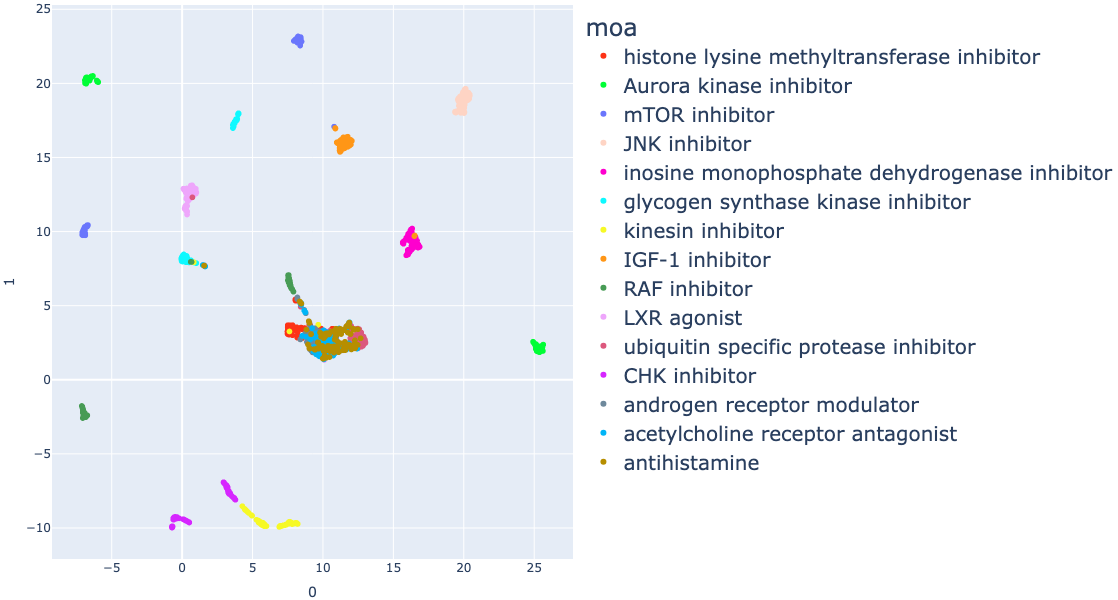

<Figure size 18000x8400 with 0 Axes>

In [11]:
plt.figure(figsize=(30, 14), dpi=dpi)
labels = MLPDF.iloc[:, -1]
hover_data = pd.DataFrame({'label': labels})

fig = px.scatter(
    embedding2.embedding_, x=0, y=1,
    color=hover_data.label, labels={'color': 'moa'},
    color_discrete_sequence=px.colors.qualitative.Light24
)

fig.update_xaxes(fixedrange=True)
fig.update_yaxes(fixedrange=True)

fig.update_layout(
    autosize=False,
    width=fig_width+400,
    height=fig_height,
    margin=dict(l=1, r=1, t=1, b=1),
    legend=dict(font=dict(size= 20))
)


fig.show()

save_path = output_root_dir + f'{dataset_name}/UMAPmlpMOA_{n_neighbors}_{dataset_name}.png'
fig.write_image(save_path, scale=3)